In [ ]:
# Depends on:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Benchmark
import time

# ⚠️ WARNING: Disable this if you're running locally (not on Google Colab)
from google.colab import files

**Download Dataset Function**

Returns the value of given dataset

In [ ]:
def loadDataset(link: str) -> pd.DataFrame:
  return pd.read_excel(link)

In [ ]:
class FuzzyInput(object):
  # Initialisation 
  def __init__(self):
    self.membership = {}

  # Membership
  def point(self, a: float, b: float, c: float, d: float) -> dict:
    return {
      'a': a,
      'b': b,
      'c': c,
      'd': d
    }
  
  def createMembership(self, linguistic: str, point: dict):
    self.membership[linguistic] = point

In [ ]:
class FuzzyOutput(object):
  # Initialisation 
  def __init__(self, id, score):
    self.id = id
    self.score = score

In [ ]:
class FuzzySystem(object):
  def __init__(self):
    self.color = color = ['r','g','b']

  def plotLinguistic(self, points: dict, color: str, label: str = '', min: int = 0, max: int = 1):
    y = [0,1,1,0]
    point = list(points.values())

    plt.plot((min, point[0]), (0,0), color)
    for i in range(len(point) - 1):
      plt.plot((point[i], point[i+1]), (y[i], y[i+1]), color)
    plt.plot((point[-1], max), (0,0), color, label=label)

  def plotMembership(self, membership, min: int = 0, max: int = 1):
    i = 0
    
    for j in membership:
      self.plotLinguistic(membership[j], self.color[i], j, min=min, max=max)
      i += 1
    
    plt.legend(loc=3)
    plt.show()
  
  def plotFairness(self, fairness):
    i = 0

    for k, v in fairness.items():
      plt.axvline(v, 0, 1, color=self.color[i], label=k)
      i += 1
    
    plt.legend()
    plt.show()

  def calculateLinguistic(self, x: int, point: dict) -> float:
    if x <= point['a'] or x >= point['d']:
      return 0
    elif point['a'] < x < point['b']:
      return (x - point['a']) / (point['b'] - point['a'])
    elif point['b'] <= x <= point['c']:
      return 1
    elif point['c'] < x <= point['d']:
      return -(x - point['d']) / (point['d'] - point['c'])

  def calculateMembership(self, x: int, membership: dict) -> list:
    return {i: self.calculateLinguistic(x, membership[i]) for i in membership.keys()}

  def fuzzification(self, x: list, input: list) -> list:
    return [self.calculateMembership(x[i], input[i]) for i in range(len(input))]

  def inference(self, fuzzificated: list, rule: dict) -> dict:
    def conjuction(a, b):
      return min(a, b)

    def disjunction(a, b):
      return max(a, b)

    result = {}

    for k1, v1 in fuzzificated[0].items():
      for k2, v2 in fuzzificated[1].items():
        r = (k1, k2)
        minVal = conjuction(v1, v2)
        currVal = result.get(rule[r], 0)
        
        result[rule[r]] = disjunction(minVal, currVal)
    
    return result
  
  def defuzzification(self, inferenced: dict, membership: dict) -> float:
    upper = 0
    lower = 0

    for i in membership:
      upper = upper + (inferenced[i] * membership[i])
      lower = lower + inferenced[i]

    try:
      return upper/lower
    except ZeroDivisionError:
      return 0

  def computeSugeno(self, x: int, membership: list, rule: dict, fairness: dict) -> float:
    fuzzificated = self.fuzzification(x, membership)
    inferenced = self.inference(fuzzificated, rule)
    return self.defuzzification(inferenced, fairness)

In [ ]:
class FuzzyRule(object):
  # Initialisation 
  def __init__(self):
    self.rule = {}

  def createRule(self, pair: tuple, value: str):
    self.rule[pair] = value

In [ ]:
def main():
  start = time.time()
  print("Hello, mom!")

  # Constant
  url = "https://raw.githubusercontent.com/mrandika/CII2M3_INTRO-AI_Reasoning/main/bengkel.xlsx"
  system = FuzzySystem()
  fairness = {
      'YES': 100,
      'CONSIDERED': 70,
      'NO': 50
  }

  # Dataset
  dataset = loadDataset(url)
  dataId = dataset['id']
  dataInput = dataset[['servis', 'harga']]

  # Input 1 (Quality) Membership
  quality = FuzzyInput()
  quality.createMembership('baik', quality.point(50,80,100,100))
  quality.createMembership('sedang', quality.point(20,30,70,80))
  quality.createMembership('buruk', quality.point(0,0,20,50))

  # Input 2 (Price) Membership
  price = FuzzyInput()
  price.createMembership('mahal', price.point(5,8,10,10))
  price.createMembership('sedang', price.point(3,5,6,8))
  price.createMembership('murah', price.point(0,0,3,5))

  # Plotted Membership
  system.plotMembership(quality.membership)
  system.plotMembership(price.membership)

  # Rules
  rules = FuzzyRule()
  rules.createRule(('baik', 'mahal'), 'CONSIDERED')
  rules.createRule(('baik', 'sedang'), 'YES')
  rules.createRule(('baik', 'murah'), 'YES')

  rules.createRule(('sedang', 'mahal'), 'CONSIDERED')
  rules.createRule(('sedang', 'sedang'), 'CONSIDERED')
  rules.createRule(('sedang', 'murah'), 'YES')

  rules.createRule(('buruk', 'mahal'), 'NO')
  rules.createRule(('buruk', 'sedang'), 'NO')
  rules.createRule(('buruk', 'murah'), 'CONSIDERED')

  print("\nFuzzy Rules")
  print("{:<10} {:<10} {:<10}".format('Servis','Harga','Score'))
  for k, v in rules.rule.items():
        print("{:<10} {:<10} {:<10}".format(k[0], k[1], v))

  # Fairness Plot
  system.plotFairness(fairness)

  # Fuzzification->Inference->Defuzzification
  defuzzifiedScore = [system.computeSugeno(i, [quality.membership, price.membership], rules.rule, fairness) for i in dataInput.values]

  # Selecting
  shops = [FuzzyOutput(i+1, defuzzifiedScore[i]) for i in range(len(defuzzifiedScore))]
  selectedShops = sorted(shops, key=lambda shop: shop.score, reverse=True)
  
  for shop in shops:
    print(f"ID:", shop.id, "Score:", shop.score)

  # Convert to DataFrame
  print("\nTop 10 shops: ")
  shopDataFrame = pd.DataFrame([(shop.id, shop.score) for shop in selectedShops[0:10]], columns=['id', 'score'])
  print(shopDataFrame)
  shopDataFrame.to_excel('worth_service.xlsx')

  # # ⚠️ WARNING: Disable this if you're running locally (not on Google Colab)
  # files.download('worth_service.xlsx')

  print(f"\nElapsed: ", time.time() - start)

Hello, mom!


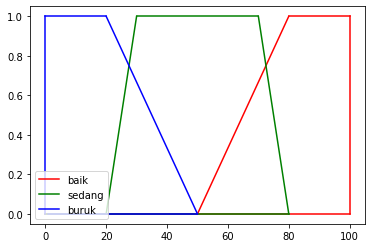

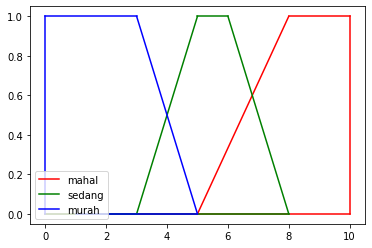


Fuzzy Rules
Servis     Harga      Score     
baik       mahal      CONSIDERED
baik       sedang     YES       
baik       murah      YES       
sedang     mahal      CONSIDERED
sedang     sedang     CONSIDERED
sedang     murah      YES       
buruk      mahal      NO        
buruk      sedang     NO        
buruk      murah      CONSIDERED


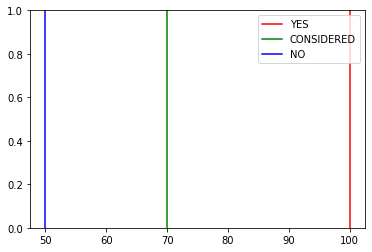

ID: 1 Score: 78.57142857142857
ID: 2 Score: 100.0
ID: 3 Score: 100.0
ID: 4 Score: 85.0
ID: 5 Score: 60.0
ID: 6 Score: 0
ID: 7 Score: 70.0
ID: 8 Score: 0
ID: 9 Score: 95.71428571428571
ID: 10 Score: 63.636363636363626
ID: 11 Score: 50.0
ID: 12 Score: 62.49999999999999
ID: 13 Score: 100.0
ID: 14 Score: 62.24489795918367
ID: 15 Score: 94.70588235294117
ID: 16 Score: 92.5
ID: 17 Score: 100.0
ID: 18 Score: 50.0
ID: 19 Score: 93.6842105263158
ID: 20 Score: 0
ID: 21 Score: 98.125
ID: 22 Score: 70.0
ID: 23 Score: 60.0
ID: 24 Score: 0
ID: 25 Score: 0
ID: 26 Score: 70.0
ID: 27 Score: 70.0
ID: 28 Score: 95.0
ID: 29 Score: 50.0
ID: 30 Score: 50.0
ID: 31 Score: 70.0
ID: 32 Score: 93.6842105263158
ID: 33 Score: 62.76595744680851
ID: 34 Score: 100.0
ID: 35 Score: 70.0
ID: 36 Score: 62.5
ID: 37 Score: 73.33333333333333
ID: 38 Score: 70.0
ID: 39 Score: 72.72727272727272
ID: 40 Score: 50.0
ID: 41 Score: 89.14893617021276
ID: 42 Score: 0
ID: 43 Score: 89.56521739130436
ID: 44 Score: 100.0
ID: 45 Score: 5

In [ ]:
if __name__ == "__main__":
  main()